In [ ]:
!pip install pydicom torchvision tqdm scikit-image

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pydicom
import cv2
import numpy as np
import torch
from glob import glob
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms


In [ ]:
def load_dicom_image(filepath):
    dicom = pydicom.dcmread(filepath)
    img = dicom.pixel_array
    img = img[:, :, 0] if len(img.shape) == 3 else img
    img_resized = cv2.resize(img, (256, 256))
    img_normalized = img_resized / img_resized.max()
    return img_normalized.astype(np.float32)

def load_dicom_mask(filepath):
    dicom = pydicom.dcmread(filepath)
    mask = dicom.pixel_array
    mask = mask[:, :, 0] if len(mask.shape) == 3 else mask
    mask_resized = cv2.resize(mask, (256, 256))
    mask_binary = (mask_resized > 50).astype(np.float32)
    return mask_binary


In [ ]:
class MRCTDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_dicom_image(self.image_paths[idx])
        mask = load_dicom_mask(self.mask_paths[idx])
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return image, mask


In [ ]:
# Paths to datasets
root_dir = '/content/drive/MyDrive/z4wc364g79-1/JUH_MR-CT_dataset'
mr_image_paths = sorted(glob(os.path.join(root_dir, 'MR/image_MR/*.dcm')))
mr_mask_paths = sorted(glob(os.path.join(root_dir, 'MR/mask_MR/*.dcm')))
ct_image_paths = sorted(glob(os.path.join(root_dir, 'CT/image_CT/*.dcm')))
ct_mask_paths = sorted(glob(os.path.join(root_dir, 'CT/mask_CT/*.dcm')))

# Split dataset into training and validation sets
train_mr_image_paths, val_mr_image_paths, train_mr_mask_paths, val_mr_mask_paths = train_test_split(
    mr_image_paths, mr_mask_paths, test_size=0.2, random_state=42
)
train_ct_image_paths, val_ct_image_paths, train_ct_mask_paths, val_ct_mask_paths = train_test_split(
    ct_image_paths, ct_mask_paths, test_size=0.2, random_state=42
)


In [ ]:
# Define augmentation transformations
augmentation_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Parameters
num_augmentations_mri = 40  # For around 2500 images
num_augmentations_ct = 40  # For around 2500 images

# Custom dataset class to apply augmentations multiple times
class AugmentedDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform, num_augmentations):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.num_augmentations = num_augmentations

    def __len__(self):
        return len(self.image_paths) * self.num_augmentations

    def __getitem__(self, idx):
        original_idx = idx % len(self.image_paths)
        image = load_dicom_image(self.image_paths[original_idx])
        mask = load_dicom_mask(self.mask_paths[original_idx])

        if self.transform:
            augmented = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        return augmented, mask

# Create augmented datasets
augmented_mri_dataset = AugmentedDataset(train_mr_image_paths, train_mr_mask_paths, augmentation_transforms, num_augmentations_mri)
augmented_ct_dataset = AugmentedDataset(train_ct_image_paths, train_ct_mask_paths, augmentation_transforms, num_augmentations_ct)

# Create DataLoaders
batch_size = 8
augmented_mri_dataloader = DataLoader(augmented_mri_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
augmented_ct_dataloader = DataLoader(augmented_ct_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Check dataset sizes
print(f"Number of augmented MRI images: {len(augmented_mri_dataset)}")
print(f"Number of augmented CT images: {len(augmented_ct_dataset)}")


Number of augmented MRI images: 2880
Number of augmented CT images: 2800


In [ ]:
# Create validation datasets without augmentation
simple_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_mr_dataset = MRCTDataset(val_mr_image_paths, val_mr_mask_paths, transform=simple_transform)
val_ct_dataset = MRCTDataset(val_ct_image_paths, val_ct_mask_paths, transform=simple_transform)

val_mr_dataloader = DataLoader(val_mr_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_ct_dataloader = DataLoader(val_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


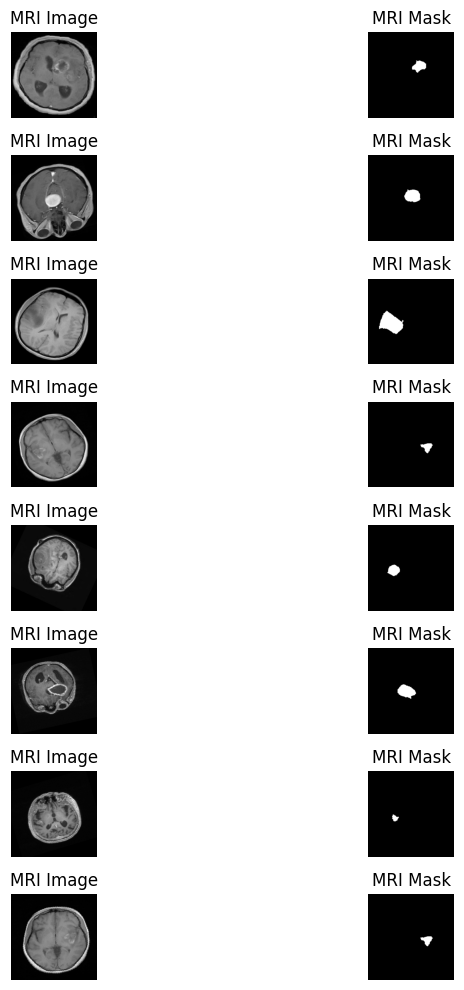

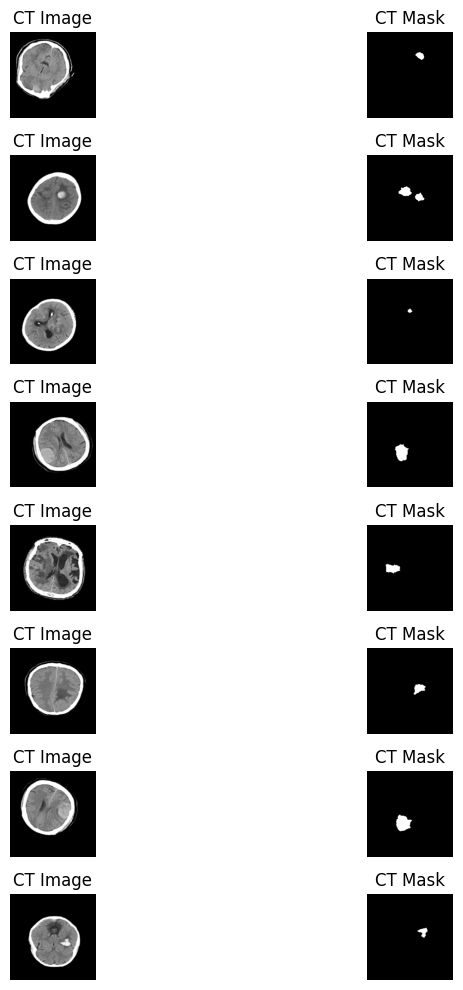

In [ ]:
import matplotlib.pyplot as plt

# Visualization function
def visualize_images(images, masks, titles):
    fig, axes = plt.subplots(len(images), 2, figsize=(10, 10))
    for i, (image, mask, title) in enumerate(zip(images, masks, titles)):
        axes[i, 0].imshow(image.squeeze(), cmap='gray')
        axes[i, 0].set_title(f'{title} Image')
        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title(f'{title} Mask')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Function to visualize a batch of images and masks from a dataloader
def visualize_batch(dataloader, title):
    images, masks = next(iter(dataloader))
    images = images.cpu().numpy()
    masks = masks.cpu().numpy()
    visualize_images(images, masks, [title] * len(images))

# Visualize MRI images and masks
visualize_batch(augmented_mri_dataloader, 'MRI')

# Visualize CT images and masks
visualize_batch(augmented_ct_dataloader, 'CT')


In [ ]:
def check_consistency(image_paths, mask_paths, dataset_name):
    print(f"Number of {dataset_name} images: {len(image_paths)}")
    print(f"Number of {dataset_name} masks: {len(mask_paths)}")
    assert len(image_paths) == len(mask_paths), f"Mismatch in number of images and masks for {dataset_name}"

# Check consistency of original datasets
check_consistency(mr_image_paths, mr_mask_paths, "MRI")
check_consistency(ct_image_paths, ct_mask_paths, "CT")

# Check consistency of training datasets
check_consistency(train_mr_image_paths, train_mr_mask_paths, "Training MRI")
check_consistency(train_ct_image_paths, train_ct_mask_paths, "Training CT")

# Check consistency of validation datasets
check_consistency(val_mr_image_paths, val_mr_mask_paths, "Validation MRI")
check_consistency(val_ct_image_paths, val_ct_mask_paths, "Validation CT")


Number of MRI images: 90
Number of MRI masks: 90
Number of CT images: 88
Number of CT masks: 88
Number of Training MRI images: 72
Number of Training MRI masks: 72
Number of Training CT images: 70
Number of Training CT masks: 70
Number of Validation MRI images: 18
Number of Validation MRI masks: 18
Number of Validation CT images: 18
Number of Validation CT masks: 18


In [ ]:
def check_image_sizes(dataloader, dataset_name):
    images, masks = next(iter(dataloader))
    print(f"Shape of {dataset_name} images: {images.shape}")
    print(f"Shape of {dataset_name} masks: {masks.shape}")

# Check image sizes for augmented datasets
check_image_sizes(augmented_mri_dataloader, "Augmented MRI")
check_image_sizes(augmented_ct_dataloader, "Augmented CT")

# Check image sizes for validation datasets
check_image_sizes(val_mr_dataloader, "Validation MRI")
check_image_sizes(val_ct_dataloader, "Validation CT")


Shape of Augmented MRI images: torch.Size([8, 1, 256, 256])
Shape of Augmented MRI masks: torch.Size([8, 1, 256, 256])
Shape of Augmented CT images: torch.Size([8, 1, 256, 256])
Shape of Augmented CT masks: torch.Size([8, 1, 256, 256])
Shape of Validation MRI images: torch.Size([8, 1, 256, 256])
Shape of Validation MRI masks: torch.Size([8, 1, 256, 256])
Shape of Validation CT images: torch.Size([8, 1, 256, 256])
Shape of Validation CT masks: torch.Size([8, 1, 256, 256])


Step 1: Defining the CycleGAN architetcure for Image Synthesis.    

Implementation of ResNet-based Generator and PatchGAN Discriminator.

Ablation Study - II

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# ResNet-based generator
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc):
        super(ResNetGenerator, self).__init__()
        model = models.resnet18(pretrained=True)
        self.input_nc = input_nc
        self.output_nc = output_nc

        # Modify the first convolution layer to accept 1-channel input
        if input_nc != 3:
            self.model = model
            self.model.conv1 = nn.Conv2d(input_nc, 64, kernel_size=7, stride=2, padding=3, bias=False)
        else:
            self.model = model

        # Extract layers except the last fully connected layer
        self.resnet_layers = nn.Sequential(*list(self.model.children())[:-2])

        # Additional layers to upsample to the original image size
        self.upsample_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, output_nc, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.resnet_layers(x)
        x = self.upsample_layers(x)
        return x

# PatchGAN discriminator
class PatchGANDiscriminator(nn.Module):
    def __init__(self, input_nc):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# VGG-based feature extractor
class VGGFeatureExtractor(nn.Module):
    def __init__(self, layers):
        super(VGGFeatureExtractor, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.layers = layers
        self.vgg = nn.ModuleList([vgg[i] for i in layers])

    def forward(self, x):
        features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.layers:
                features.append(x)
        return features

# Instantiate the feature extractor
feature_extractor = VGGFeatureExtractor([3, 8, 17]).to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
!pip install torchmetrics

Ablation Study - III (Incorporating SSIM Loss in the Training Loop)

In [ ]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchmetrics.functional import structural_similarity_index_measure
from tqdm import tqdm

# Function to compute feature adaptation loss
def compute_feature_adaptation_loss(real_img, fake_img, feature_extractor):
    real_features = feature_extractor(real_img)
    fake_features = feature_extractor(fake_img)
    loss = 0
    for real_feature, fake_feature in zip(real_features, fake_features):
        loss += nn.functional.l1_loss(fake_feature, real_feature)
    return loss

# SSIM loss function
def ssim_loss(img1, img2):
    return 1 - structural_similarity_index_measure(img1, img2, data_range=1.0)

# Initialize models
G_MRI_to_CT = ResNetGenerator(input_nc=1, output_nc=1).to(device)
G_CT_to_MRI = ResNetGenerator(input_nc=1, output_nc=1).to(device)
D_MRI = PatchGANDiscriminator(input_nc=1).to(device)
D_CT = PatchGANDiscriminator(input_nc=1).to(device)

# Define loss functions
adversarial_loss = nn.MSELoss().to(device)
cycle_loss = nn.L1Loss().to(device)
identity_loss = nn.L1Loss().to(device)

# Define optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_MRI_to_CT.parameters(), G_CT_to_MRI.parameters()), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D_MRI = torch.optim.Adam(D_MRI.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D_CT = torch.optim.Adam(D_CT.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-5)

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100)
lr_scheduler_D_MRI = torch.optim.lr_scheduler.LambdaLR(optimizer_D_MRI, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100)
lr_scheduler_D_CT = torch.optim.lr_scheduler.LambdaLR(optimizer_D_CT, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100)

# Training loop
num_epochs = 150
lambda_feature = 10  # Weight for feature adaptation loss
lambda_ssim = 0.5 # Weight for SSIM loss

for epoch in range(num_epochs):
    for i, ((real_mri, _), (real_ct, _)) in tqdm(enumerate(zip(augmented_mri_dataloader, augmented_ct_dataloader)), total=min(len(augmented_mri_dataloader), len(augmented_ct_dataloader))):
        # Ensure same batch size
        if real_mri.size(0) != real_ct.size(0):
            min_batch_size = min(real_mri.size(0), real_ct.size(0))
            real_mri = real_mri[:min_batch_size]
            real_ct = real_ct[:min_batch_size]

        # Transfer to GPU if available
        real_mri = real_mri.to(device)
        real_ct = real_ct.to(device)

        # Generators forward pass
        fake_ct = G_MRI_to_CT(real_mri)
        recov_mri = G_CT_to_MRI(fake_ct)
        fake_mri = G_CT_to_MRI(real_ct)
        recov_ct = G_MRI_to_CT(fake_mri)

        # Training Discriminators
        optimizer_D_MRI.zero_grad()
        optimizer_D_CT.zero_grad()

        # Real loss
        loss_D_MRI_real = adversarial_loss(D_MRI(real_mri), torch.ones_like(D_MRI(real_mri)))
        loss_D_CT_real = adversarial_loss(D_CT(real_ct), torch.ones_like(D_CT(real_ct)))

        # Fake loss
        loss_D_MRI_fake = adversarial_loss(D_MRI(fake_mri.detach()), torch.zeros_like(D_MRI(fake_mri)))
        loss_D_CT_fake = adversarial_loss(D_CT(fake_ct.detach()), torch.zeros_like(D_CT(fake_ct)))

        # Total discriminator loss
        loss_D_MRI = (loss_D_MRI_real + loss_D_MRI_fake) * 0.5
        loss_D_CT = (loss_D_CT_real + loss_D_CT_fake) * 0.5

        loss_D_MRI.backward()
        loss_D_CT.backward()
        optimizer_D_MRI.step()
        optimizer_D_CT.step()

        # Training Generators
        optimizer_G.zero_grad()

        # Identity loss
        loss_identity_MRI = identity_loss(G_CT_to_MRI(real_mri), real_mri)
        loss_identity_CT = identity_loss(G_MRI_to_CT(real_ct), real_ct)

        # Cycle consistency loss
        loss_cycle_MRI = cycle_loss(recov_mri, real_mri)
        loss_cycle_CT = cycle_loss(recov_ct, real_ct)

        # Feature adaptation loss
        real_mri_3ch = real_mri.repeat(1, 3, 1, 1)
        fake_mri_3ch = fake_mri.repeat(1, 3, 1, 1)
        real_ct_3ch = real_ct.repeat(1, 3, 1, 1)
        fake_ct_3ch = fake_ct.repeat(1, 3, 1, 1)

        feature_loss_MRI = compute_feature_adaptation_loss(real_mri_3ch, fake_mri_3ch, feature_extractor)
        feature_loss_CT = compute_feature_adaptation_loss(real_ct_3ch, fake_ct_3ch, feature_extractor)

        # SSIM loss
        loss_ssim_MRI_to_CT = ssim_loss(fake_ct, real_ct)
        loss_ssim_CT_to_MRI = ssim_loss(fake_mri, real_mri)

        # Adversarial loss
        loss_G_MRI_to_CT = adversarial_loss(D_CT(fake_ct), torch.ones_like(D_CT(fake_ct)))
        loss_G_CT_to_MRI = adversarial_loss(D_MRI(fake_mri), torch.ones_like(D_MRI(fake_mri)))

        # Total generator loss
        loss_G = (loss_G_MRI_to_CT + loss_G_CT_to_MRI
                  + 10.0 * (loss_cycle_MRI + loss_cycle_CT)
                  + 5.0 * (loss_identity_MRI + loss_identity_CT)
                  + lambda_feature * (feature_loss_MRI + feature_loss_CT)
                  + lambda_ssim * (loss_ssim_MRI_to_CT + loss_ssim_CT_to_MRI))

        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D_MRI: {loss_D_MRI.item()} Loss_D_CT: {loss_D_CT.item()} Loss_G: {loss_G.item()}")

    # Step learning rate schedulers
    lr_scheduler_G.step()
    lr_scheduler_D_MRI.step()
    lr_scheduler_D_CT.step()


100%|██████████| 350/350 [01:04<00:00,  5.40it/s]

Epoch [1/150] Loss_D_MRI: 0.14831705391407013 Loss_D_CT: 0.15868857502937317 Loss_G: 5.045848846435547



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [2/150] Loss_D_MRI: 0.18788549304008484 Loss_D_CT: 0.18408328294754028 Loss_G: 4.730423450469971



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [3/150] Loss_D_MRI: 0.20139282941818237 Loss_D_CT: 0.18995842337608337 Loss_G: 3.701744318008423



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [4/150] Loss_D_MRI: 0.18649055063724518 Loss_D_CT: 0.2270510494709015 Loss_G: 3.841203212738037



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [5/150] Loss_D_MRI: 0.2619236409664154 Loss_D_CT: 0.1900641769170761 Loss_G: 4.6256608963012695



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [6/150] Loss_D_MRI: 0.2286570966243744 Loss_D_CT: 0.23846250772476196 Loss_G: 3.0699784755706787



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [7/150] Loss_D_MRI: 0.2147587537765503 Loss_D_CT: 0.24165937304496765 Loss_G: 3.735051155090332



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [8/150] Loss_D_MRI: 0.20362193882465363 Loss_D_CT: 0.19302132725715637 Loss_G: 3.749392032623291



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [9/150] Loss_D_MRI: 0.18117240071296692 Loss_D_CT: 0.20247100293636322 Loss_G: 3.3865976333618164



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [10/150] Loss_D_MRI: 0.23150628805160522 Loss_D_CT: 0.17723190784454346 Loss_G: 3.533708095550537



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [11/150] Loss_D_MRI: 0.22360150516033173 Loss_D_CT: 0.21077755093574524 Loss_G: 3.4360947608947754



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [12/150] Loss_D_MRI: 0.21450810134410858 Loss_D_CT: 0.2424796223640442 Loss_G: 3.143416166305542



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [13/150] Loss_D_MRI: 0.2331620752811432 Loss_D_CT: 0.22558805346488953 Loss_G: 2.991015672683716



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [14/150] Loss_D_MRI: 0.23098888993263245 Loss_D_CT: 0.2610938847064972 Loss_G: 3.777224540710449



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [15/150] Loss_D_MRI: 0.22014421224594116 Loss_D_CT: 0.1628517359495163 Loss_G: 3.39700984954834



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [16/150] Loss_D_MRI: 0.2178487628698349 Loss_D_CT: 0.258962482213974 Loss_G: 3.0693321228027344



100%|██████████| 350/350 [01:04<00:00,  5.46it/s]

Epoch [17/150] Loss_D_MRI: 0.21177926659584045 Loss_D_CT: 0.19176296889781952 Loss_G: 3.1902284622192383



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [18/150] Loss_D_MRI: 0.23578937351703644 Loss_D_CT: 0.19027939438819885 Loss_G: 3.0016512870788574



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [19/150] Loss_D_MRI: 0.22064223885536194 Loss_D_CT: 0.24207477271556854 Loss_G: 3.1189768314361572



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [20/150] Loss_D_MRI: 0.24053481221199036 Loss_D_CT: 0.2685961127281189 Loss_G: 2.693722724914551



100%|██████████| 350/350 [01:04<00:00,  5.46it/s]

Epoch [21/150] Loss_D_MRI: 0.2050175964832306 Loss_D_CT: 0.23993629217147827 Loss_G: 3.295762777328491



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [22/150] Loss_D_MRI: 0.24593442678451538 Loss_D_CT: 0.19992953538894653 Loss_G: 2.8834285736083984



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [23/150] Loss_D_MRI: 0.23127004504203796 Loss_D_CT: 0.17915908992290497 Loss_G: 2.90841007232666



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [24/150] Loss_D_MRI: 0.25057554244995117 Loss_D_CT: 0.21590813994407654 Loss_G: 3.227160930633545



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [25/150] Loss_D_MRI: 0.21254447102546692 Loss_D_CT: 0.20480506122112274 Loss_G: 3.169481039047241



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [26/150] Loss_D_MRI: 0.2816852629184723 Loss_D_CT: 0.20682457089424133 Loss_G: 3.55521559715271



100%|██████████| 350/350 [01:04<00:00,  5.42it/s]

Epoch [27/150] Loss_D_MRI: 0.24493616819381714 Loss_D_CT: 0.22971756756305695 Loss_G: 2.8067917823791504



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [28/150] Loss_D_MRI: 0.2492026388645172 Loss_D_CT: 0.24694135785102844 Loss_G: 2.731706142425537



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [29/150] Loss_D_MRI: 0.2511991262435913 Loss_D_CT: 0.2441215217113495 Loss_G: 2.6962833404541016



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [30/150] Loss_D_MRI: 0.255212664604187 Loss_D_CT: 0.2275378704071045 Loss_G: 2.55558705329895



100%|██████████| 350/350 [01:04<00:00,  5.46it/s]

Epoch [31/150] Loss_D_MRI: 0.24441657960414886 Loss_D_CT: 0.23438352346420288 Loss_G: 2.8231542110443115



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [32/150] Loss_D_MRI: 0.20947304368019104 Loss_D_CT: 0.2458476573228836 Loss_G: 3.249732494354248



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [33/150] Loss_D_MRI: 0.23167820274829865 Loss_D_CT: 0.28396064043045044 Loss_G: 2.5846095085144043



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [34/150] Loss_D_MRI: 0.24489018321037292 Loss_D_CT: 0.23743313550949097 Loss_G: 2.6905782222747803



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [35/150] Loss_D_MRI: 0.24354128539562225 Loss_D_CT: 0.23589205741882324 Loss_G: 2.5492005348205566



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [36/150] Loss_D_MRI: 0.2419569492340088 Loss_D_CT: 0.2435404360294342 Loss_G: 2.733875036239624



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [37/150] Loss_D_MRI: 0.22821737825870514 Loss_D_CT: 0.2284533977508545 Loss_G: 2.774995803833008



100%|██████████| 350/350 [01:04<00:00,  5.42it/s]

Epoch [38/150] Loss_D_MRI: 0.24809090793132782 Loss_D_CT: 0.2531973719596863 Loss_G: 2.475876808166504



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [39/150] Loss_D_MRI: 0.22365343570709229 Loss_D_CT: 0.24591335654258728 Loss_G: 2.8361124992370605



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [40/150] Loss_D_MRI: 0.2492503523826599 Loss_D_CT: 0.23372304439544678 Loss_G: 2.5678045749664307



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [41/150] Loss_D_MRI: 0.24205762147903442 Loss_D_CT: 0.20230761170387268 Loss_G: 2.845898151397705



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [42/150] Loss_D_MRI: 0.23782899975776672 Loss_D_CT: 0.22333437204360962 Loss_G: 2.678164482116699



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [43/150] Loss_D_MRI: 0.2898011803627014 Loss_D_CT: 0.23838019371032715 Loss_G: 2.6272568702697754



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [44/150] Loss_D_MRI: 0.24481603503227234 Loss_D_CT: 0.25305336713790894 Loss_G: 2.4223151206970215



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [45/150] Loss_D_MRI: 0.2507131099700928 Loss_D_CT: 0.2233269214630127 Loss_G: 2.844785213470459



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [46/150] Loss_D_MRI: 0.22374433279037476 Loss_D_CT: 0.22046753764152527 Loss_G: 2.9361143112182617



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [47/150] Loss_D_MRI: 0.22168003022670746 Loss_D_CT: 0.2344830483198166 Loss_G: 3.2288002967834473



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [48/150] Loss_D_MRI: 0.2522728741168976 Loss_D_CT: 0.2213384509086609 Loss_G: 2.712932825088501



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [49/150] Loss_D_MRI: 0.24424052238464355 Loss_D_CT: 0.2457258105278015 Loss_G: 2.8280909061431885



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [50/150] Loss_D_MRI: 0.24884669482707977 Loss_D_CT: 0.2368859499692917 Loss_G: 2.4589357376098633



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [51/150] Loss_D_MRI: 0.23968921601772308 Loss_D_CT: 0.2508839964866638 Loss_G: 2.6646924018859863



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [52/150] Loss_D_MRI: 0.2239769697189331 Loss_D_CT: 0.25154542922973633 Loss_G: 2.521937847137451



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [53/150] Loss_D_MRI: 0.2396649569272995 Loss_D_CT: 0.2134419083595276 Loss_G: 2.5783629417419434



100%|██████████| 350/350 [01:04<00:00,  5.42it/s]

Epoch [54/150] Loss_D_MRI: 0.2794201374053955 Loss_D_CT: 0.23569339513778687 Loss_G: 2.6167845726013184



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [55/150] Loss_D_MRI: 0.24894337356090546 Loss_D_CT: 0.22082611918449402 Loss_G: 3.0598013401031494



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [56/150] Loss_D_MRI: 0.2250981330871582 Loss_D_CT: 0.22689419984817505 Loss_G: 2.65592098236084



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [57/150] Loss_D_MRI: 0.18925730884075165 Loss_D_CT: 0.19312559068202972 Loss_G: 3.5734572410583496



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [58/150] Loss_D_MRI: 0.21452075242996216 Loss_D_CT: 0.1838625967502594 Loss_G: 2.816624879837036



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [59/150] Loss_D_MRI: 0.24685923755168915 Loss_D_CT: 0.2634629011154175 Loss_G: 2.632218599319458



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [60/150] Loss_D_MRI: 0.23792263865470886 Loss_D_CT: 0.24626511335372925 Loss_G: 2.335841655731201



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [61/150] Loss_D_MRI: 0.23315918445587158 Loss_D_CT: 0.2515728771686554 Loss_G: 2.5012431144714355



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [62/150] Loss_D_MRI: 0.19762492179870605 Loss_D_CT: 0.33715689182281494 Loss_G: 2.454007148742676



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [63/150] Loss_D_MRI: 0.24784551560878754 Loss_D_CT: 0.20310825109481812 Loss_G: 2.8454742431640625



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [64/150] Loss_D_MRI: 0.19985657930374146 Loss_D_CT: 0.17675131559371948 Loss_G: 2.887824296951294



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [65/150] Loss_D_MRI: 0.25329598784446716 Loss_D_CT: 0.2045396864414215 Loss_G: 2.65299654006958



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [66/150] Loss_D_MRI: 0.24753624200820923 Loss_D_CT: 0.16001452505588531 Loss_G: 2.5329108238220215



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [67/150] Loss_D_MRI: 0.2503569722175598 Loss_D_CT: 0.14947456121444702 Loss_G: 2.9846086502075195



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [68/150] Loss_D_MRI: 0.24202847480773926 Loss_D_CT: 0.25022661685943604 Loss_G: 2.588244915008545



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [69/150] Loss_D_MRI: 0.20086711645126343 Loss_D_CT: 0.2496500313282013 Loss_G: 2.434436798095703



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [70/150] Loss_D_MRI: 0.22421646118164062 Loss_D_CT: 0.2466028928756714 Loss_G: 2.4195384979248047



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [71/150] Loss_D_MRI: 0.27129292488098145 Loss_D_CT: 0.25951266288757324 Loss_G: 2.4684677124023438



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [72/150] Loss_D_MRI: 0.22422346472740173 Loss_D_CT: 0.24589082598686218 Loss_G: 2.496370315551758



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [73/150] Loss_D_MRI: 0.19170382618904114 Loss_D_CT: 0.23876959085464478 Loss_G: 2.6575753688812256



100%|██████████| 350/350 [01:04<00:00,  5.42it/s]

Epoch [74/150] Loss_D_MRI: 0.2257656455039978 Loss_D_CT: 0.2615275979042053 Loss_G: 2.7516422271728516



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [75/150] Loss_D_MRI: 0.19475418329238892 Loss_D_CT: 0.24758955836296082 Loss_G: 2.863279104232788



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [76/150] Loss_D_MRI: 0.18977504968643188 Loss_D_CT: 0.25388824939727783 Loss_G: 2.6620359420776367



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [77/150] Loss_D_MRI: 0.24694758653640747 Loss_D_CT: 0.22998127341270447 Loss_G: 2.613804340362549



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [78/150] Loss_D_MRI: 0.24365630745887756 Loss_D_CT: 0.2530026435852051 Loss_G: 2.4331328868865967



100%|██████████| 350/350 [01:04<00:00,  5.46it/s]

Epoch [79/150] Loss_D_MRI: 0.24111205339431763 Loss_D_CT: 0.21536433696746826 Loss_G: 2.496058225631714



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [80/150] Loss_D_MRI: 0.22156360745429993 Loss_D_CT: 0.2742975056171417 Loss_G: 2.9366331100463867



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [81/150] Loss_D_MRI: 0.21382218599319458 Loss_D_CT: 0.2403213083744049 Loss_G: 2.60512638092041



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [82/150] Loss_D_MRI: 0.20885473489761353 Loss_D_CT: 0.23206815123558044 Loss_G: 2.554196834564209



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [83/150] Loss_D_MRI: 0.209474116563797 Loss_D_CT: 0.21665653586387634 Loss_G: 2.660109519958496



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [84/150] Loss_D_MRI: 0.21352824568748474 Loss_D_CT: 0.2611740827560425 Loss_G: 2.78878116607666



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [85/150] Loss_D_MRI: 0.22513234615325928 Loss_D_CT: 0.2638912796974182 Loss_G: 2.4079785346984863



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [86/150] Loss_D_MRI: 0.20046785473823547 Loss_D_CT: 0.25615012645721436 Loss_G: 2.376824378967285



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [87/150] Loss_D_MRI: 0.21147339046001434 Loss_D_CT: 0.25951439142227173 Loss_G: 2.482938289642334



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [88/150] Loss_D_MRI: 0.18240652978420258 Loss_D_CT: 0.242192804813385 Loss_G: 2.7109317779541016



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [89/150] Loss_D_MRI: 0.23508870601654053 Loss_D_CT: 0.22957256436347961 Loss_G: 2.756960391998291



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [90/150] Loss_D_MRI: 0.23877152800559998 Loss_D_CT: 0.2227696180343628 Loss_G: 2.5342650413513184



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [91/150] Loss_D_MRI: 0.24196627736091614 Loss_D_CT: 0.24829056859016418 Loss_G: 2.6974849700927734



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [92/150] Loss_D_MRI: 0.25200119614601135 Loss_D_CT: 0.22572150826454163 Loss_G: 2.3198843002319336



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [93/150] Loss_D_MRI: 0.27120348811149597 Loss_D_CT: 0.21605399250984192 Loss_G: 2.4516544342041016



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [94/150] Loss_D_MRI: 0.2317262589931488 Loss_D_CT: 0.2140512764453888 Loss_G: 3.2008767127990723



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [95/150] Loss_D_MRI: 0.2342248260974884 Loss_D_CT: 0.19606062769889832 Loss_G: 2.5266432762145996



100%|██████████| 350/350 [01:04<00:00,  5.42it/s]

Epoch [96/150] Loss_D_MRI: 0.23517078161239624 Loss_D_CT: 0.2508702278137207 Loss_G: 2.3923373222351074



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [97/150] Loss_D_MRI: 0.22817161679267883 Loss_D_CT: 0.2423923909664154 Loss_G: 2.4519052505493164



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [98/150] Loss_D_MRI: 0.21621769666671753 Loss_D_CT: 0.25120633840560913 Loss_G: 2.5689423084259033



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [99/150] Loss_D_MRI: 0.26396673917770386 Loss_D_CT: 0.2481318712234497 Loss_G: 2.790951728820801



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [100/150] Loss_D_MRI: 0.2151845246553421 Loss_D_CT: 0.24422281980514526 Loss_G: 2.5477254390716553



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [101/150] Loss_D_MRI: 0.20885194838047028 Loss_D_CT: 0.2517052888870239 Loss_G: 2.670093536376953



100%|██████████| 350/350 [01:04<00:00,  5.42it/s]

Epoch [102/150] Loss_D_MRI: 0.2096111923456192 Loss_D_CT: 0.24558475613594055 Loss_G: 2.5945138931274414



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [103/150] Loss_D_MRI: 0.1979527771472931 Loss_D_CT: 0.24227707087993622 Loss_G: 2.632554531097412



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [104/150] Loss_D_MRI: 0.20462781190872192 Loss_D_CT: 0.2543293535709381 Loss_G: 2.679938793182373



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [105/150] Loss_D_MRI: 0.22463446855545044 Loss_D_CT: 0.23098435997962952 Loss_G: 2.520946502685547



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [106/150] Loss_D_MRI: 0.22176171839237213 Loss_D_CT: 0.2332664132118225 Loss_G: 2.7495806217193604



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [107/150] Loss_D_MRI: 0.2662530839443207 Loss_D_CT: 0.24875953793525696 Loss_G: 2.4474434852600098



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [108/150] Loss_D_MRI: 0.2157721221446991 Loss_D_CT: 0.20564410090446472 Loss_G: 2.612419366836548



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [109/150] Loss_D_MRI: 0.20015665888786316 Loss_D_CT: 0.2146611213684082 Loss_G: 2.7830777168273926



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [110/150] Loss_D_MRI: 0.20829948782920837 Loss_D_CT: 0.25261566042900085 Loss_G: 2.672693967819214



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [111/150] Loss_D_MRI: 0.20836403965950012 Loss_D_CT: 0.24637934565544128 Loss_G: 2.6743721961975098



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [112/150] Loss_D_MRI: 0.23431473970413208 Loss_D_CT: 0.2383725494146347 Loss_G: 2.558826446533203



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [113/150] Loss_D_MRI: 0.19775208830833435 Loss_D_CT: 0.25189876556396484 Loss_G: 2.472015380859375



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [114/150] Loss_D_MRI: 0.21838904917240143 Loss_D_CT: 0.2537078857421875 Loss_G: 2.5199434757232666



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [115/150] Loss_D_MRI: 0.22505024075508118 Loss_D_CT: 0.24995939433574677 Loss_G: 2.4556448459625244



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [116/150] Loss_D_MRI: 0.18729712069034576 Loss_D_CT: 0.24170753359794617 Loss_G: 2.7231321334838867



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [117/150] Loss_D_MRI: 0.19775791466236115 Loss_D_CT: 0.2401321530342102 Loss_G: 2.461738348007202



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [118/150] Loss_D_MRI: 0.18331442773342133 Loss_D_CT: 0.2477685809135437 Loss_G: 2.52773380279541



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [119/150] Loss_D_MRI: 0.18970271944999695 Loss_D_CT: 0.2396121770143509 Loss_G: 2.554192543029785



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [120/150] Loss_D_MRI: 0.201569601893425 Loss_D_CT: 0.20574986934661865 Loss_G: 2.6768269538879395



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [121/150] Loss_D_MRI: 0.2044718861579895 Loss_D_CT: 0.18766652047634125 Loss_G: 2.538149118423462



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [122/150] Loss_D_MRI: 0.1709255874156952 Loss_D_CT: 0.200252965092659 Loss_G: 3.051835536956787



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [123/150] Loss_D_MRI: 0.22397936880588531 Loss_D_CT: 0.20369571447372437 Loss_G: 2.867558240890503



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [124/150] Loss_D_MRI: 0.16921618580818176 Loss_D_CT: 0.1892472207546234 Loss_G: 2.815319538116455



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [125/150] Loss_D_MRI: 0.16261827945709229 Loss_D_CT: 0.24024730920791626 Loss_G: 2.9429092407226562



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [126/150] Loss_D_MRI: 0.22431614995002747 Loss_D_CT: 0.22852924466133118 Loss_G: 2.410860061645508



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [127/150] Loss_D_MRI: 0.19549837708473206 Loss_D_CT: 0.25394099950790405 Loss_G: 2.6041839122772217



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [128/150] Loss_D_MRI: 0.17954230308532715 Loss_D_CT: 0.20700128376483917 Loss_G: 2.696183204650879



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [129/150] Loss_D_MRI: 0.20053760707378387 Loss_D_CT: 0.19494637846946716 Loss_G: 2.647515058517456



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [130/150] Loss_D_MRI: 0.16123026609420776 Loss_D_CT: 0.20874357223510742 Loss_G: 2.595581531524658



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [131/150] Loss_D_MRI: 0.20511317253112793 Loss_D_CT: 0.2063000500202179 Loss_G: 2.9009268283843994



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [132/150] Loss_D_MRI: 0.20711427927017212 Loss_D_CT: 0.17083343863487244 Loss_G: 3.0135252475738525



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [133/150] Loss_D_MRI: 0.2496919333934784 Loss_D_CT: 0.21045608818531036 Loss_G: 2.5072884559631348



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [134/150] Loss_D_MRI: 0.18097639083862305 Loss_D_CT: 0.17388087511062622 Loss_G: 2.770474672317505



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [135/150] Loss_D_MRI: 0.19952517747879028 Loss_D_CT: 0.1810624748468399 Loss_G: 2.8689041137695312



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [136/150] Loss_D_MRI: 0.2112770676612854 Loss_D_CT: 0.18681621551513672 Loss_G: 2.5131187438964844



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [137/150] Loss_D_MRI: 0.20590250194072723 Loss_D_CT: 0.1833156943321228 Loss_G: 2.6462535858154297



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [138/150] Loss_D_MRI: 0.24392251670360565 Loss_D_CT: 0.22775235772132874 Loss_G: 2.594200611114502



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [139/150] Loss_D_MRI: 0.2157791703939438 Loss_D_CT: 0.24691827595233917 Loss_G: 2.463421106338501



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [140/150] Loss_D_MRI: 0.17756858468055725 Loss_D_CT: 0.2091628760099411 Loss_G: 2.6977627277374268



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [141/150] Loss_D_MRI: 0.19894906878471375 Loss_D_CT: 0.1867721974849701 Loss_G: 2.7853341102600098



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [142/150] Loss_D_MRI: 0.18151138722896576 Loss_D_CT: 0.16938331723213196 Loss_G: 2.6775388717651367



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [143/150] Loss_D_MRI: 0.17389985918998718 Loss_D_CT: 0.21457266807556152 Loss_G: 2.5872325897216797



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [144/150] Loss_D_MRI: 0.19591787457466125 Loss_D_CT: 0.17828264832496643 Loss_G: 2.555908679962158



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [145/150] Loss_D_MRI: 0.17530472576618195 Loss_D_CT: 0.19058716297149658 Loss_G: 2.71313214302063



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [146/150] Loss_D_MRI: 0.16643761098384857 Loss_D_CT: 0.184341698884964 Loss_G: 2.718269109725952



100%|██████████| 350/350 [01:04<00:00,  5.45it/s]

Epoch [147/150] Loss_D_MRI: 0.1886182576417923 Loss_D_CT: 0.14710856974124908 Loss_G: 2.710905075073242



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [148/150] Loss_D_MRI: 0.1638544499874115 Loss_D_CT: 0.14704427123069763 Loss_G: 2.9427919387817383



100%|██████████| 350/350 [01:04<00:00,  5.44it/s]

Epoch [149/150] Loss_D_MRI: 0.1978532075881958 Loss_D_CT: 0.17045381665229797 Loss_G: 2.682985782623291



100%|██████████| 350/350 [01:04<00:00,  5.43it/s]

Epoch [150/150] Loss_D_MRI: 0.17369383573532104 Loss_D_CT: 0.15276283025741577 Loss_G: 2.952636480331421


Ablation Study - II (Training Loop without SSIM Loss)

In [ ]:
import itertools
# Function to compute feature adaptation loss
def compute_feature_adaptation_loss(real_img, fake_img, feature_extractor):
    real_features = feature_extractor(real_img)
    fake_features = feature_extractor(fake_img)
    loss = 0
    for real_feature, fake_feature in zip(real_features, fake_features):
        loss += nn.functional.l1_loss(fake_feature, real_feature)
    return loss

# Initialize models
G_MRI_to_CT = ResNetGenerator(input_nc=1, output_nc=1).to(device)
G_CT_to_MRI = ResNetGenerator(input_nc=1, output_nc=1).to(device)
D_MRI = PatchGANDiscriminator(input_nc=1).to(device)
D_CT = PatchGANDiscriminator(input_nc=1).to(device)

# Define loss functions
adversarial_loss = nn.MSELoss().to(device)
cycle_loss = nn.L1Loss().to(device)
identity_loss = nn.L1Loss().to(device)

# Define optimizers
optimizer_G = torch.optim.Adam(itertools.chain(G_MRI_to_CT.parameters(), G_CT_to_MRI.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_MRI = torch.optim.Adam(D_MRI.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_CT = torch.optim.Adam(D_CT.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Learning rate schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100)
lr_scheduler_D_MRI = torch.optim.lr_scheduler.LambdaLR(optimizer_D_MRI, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100)
lr_scheduler_D_CT = torch.optim.lr_scheduler.LambdaLR(optimizer_D_CT, lr_lambda=lambda epoch: 1.0 - max(0, epoch - 100) / 100)

# Training loop
num_epochs = 200
lambda_feature = 10  # Weight for feature adaptation loss

for epoch in range(num_epochs):
    for i, ((real_mri, _), (real_ct, _)) in tqdm(enumerate(zip(augmented_mri_dataloader, augmented_ct_dataloader)), total=min(len(augmented_mri_dataloader), len(augmented_ct_dataloader))):
        # Transfer to GPU if available
        real_mri = real_mri.to(device)
        real_ct = real_ct.to(device)

        # Generators forward pass
        fake_ct = G_MRI_to_CT(real_mri)
        recov_mri = G_CT_to_MRI(fake_ct)
        fake_mri = G_CT_to_MRI(real_ct)
        recov_ct = G_MRI_to_CT(fake_mri)

        # Training Discriminators
        optimizer_D_MRI.zero_grad()
        optimizer_D_CT.zero_grad()

        # Real loss
        loss_D_MRI_real = adversarial_loss(D_MRI(real_mri), torch.ones_like(D_MRI(real_mri)))
        loss_D_CT_real = adversarial_loss(D_CT(real_ct), torch.ones_like(D_CT(real_ct)))

        # Fake loss
        loss_D_MRI_fake = adversarial_loss(D_MRI(fake_mri.detach()), torch.zeros_like(D_MRI(fake_mri)))
        loss_D_CT_fake = adversarial_loss(D_CT(fake_ct.detach()), torch.zeros_like(D_CT(fake_ct)))

        # Total discriminator loss
        loss_D_MRI = (loss_D_MRI_real + loss_D_MRI_fake) * 0.5
        loss_D_CT = (loss_D_CT_real + loss_D_CT_fake) * 0.5

        loss_D_MRI.backward()
        loss_D_CT.backward()
        optimizer_D_MRI.step()
        optimizer_D_CT.step()

        # Training Generators
        optimizer_G.zero_grad()

        # Identity loss
        loss_identity_MRI = identity_loss(G_CT_to_MRI(real_mri), real_mri)
        loss_identity_CT = identity_loss(G_MRI_to_CT(real_ct), real_ct)

        # Cycle consistency loss
        loss_cycle_MRI = cycle_loss(recov_mri, real_mri)
        loss_cycle_CT = cycle_loss(recov_ct, real_ct)

        # Feature adaptation loss
        real_mri_3ch = real_mri.repeat(1, 3, 1, 1)
        fake_mri_3ch = fake_mri.repeat(1, 3, 1, 1)
        real_ct_3ch = real_ct.repeat(1, 3, 1, 1)
        fake_ct_3ch = fake_ct.repeat(1, 3, 1, 1)

        feature_loss_MRI = compute_feature_adaptation_loss(real_mri_3ch, fake_mri_3ch, feature_extractor)
        feature_loss_CT = compute_feature_adaptation_loss(real_ct_3ch, fake_ct_3ch, feature_extractor)

        # Adversarial loss
        loss_G_MRI_to_CT = adversarial_loss(D_CT(fake_ct), torch.ones_like(D_CT(fake_ct)))
        loss_G_CT_to_MRI = adversarial_loss(D_MRI(fake_mri), torch.ones_like(D_MRI(fake_mri)))

        # Total generator loss
        loss_G = (loss_G_MRI_to_CT + loss_G_CT_to_MRI
                  + 10.0 * (loss_cycle_MRI + loss_cycle_CT)
                  + 5.0 * (loss_identity_MRI + loss_identity_CT)
                  + lambda_feature * (feature_loss_MRI + feature_loss_CT))

        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss_D_MRI: {loss_D_MRI.item()} Loss_D_CT: {loss_D_CT.item()} Loss_G: {loss_G.item()}")

    # Step learning rate schedulers
    lr_scheduler_G.step()
    lr_scheduler_D_MRI.step()
    lr_scheduler_D_CT.step()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [1/200] Loss_D_MRI: 0.15364789962768555 Loss_D_CT: 0.03286004438996315 Loss_G: 6.4857940673828125



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [2/200] Loss_D_MRI: 0.21637442708015442 Loss_D_CT: 0.10782305896282196 Loss_G: 5.738869667053223



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [3/200] Loss_D_MRI: 0.16466644406318665 Loss_D_CT: 0.16385126113891602 Loss_G: 4.480669975280762



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [4/200] Loss_D_MRI: 0.1618286520242691 Loss_D_CT: 0.16586630046367645 Loss_G: 4.185548782348633



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [5/200] Loss_D_MRI: 0.20155012607574463 Loss_D_CT: 0.20358721911907196 Loss_G: 3.385745048522949



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [6/200] Loss_D_MRI: 0.1826491802930832 Loss_D_CT: 0.27924540638923645 Loss_G: 3.962397575378418



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [7/200] Loss_D_MRI: 0.23069897294044495 Loss_D_CT: 0.18171408772468567 Loss_G: 3.5476222038269043



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [8/200] Loss_D_MRI: 0.15100020170211792 Loss_D_CT: 0.15232393145561218 Loss_G: 3.4296324253082275



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [9/200] Loss_D_MRI: 0.18719607591629028 Loss_D_CT: 0.2391524463891983 Loss_G: 3.2878832817077637



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [10/200] Loss_D_MRI: 0.25209954380989075 Loss_D_CT: 0.20405329763889313 Loss_G: 3.4352245330810547



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [11/200] Loss_D_MRI: 0.1935335099697113 Loss_D_CT: 0.19678758084774017 Loss_G: 3.2647156715393066



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [12/200] Loss_D_MRI: 0.2190314531326294 Loss_D_CT: 0.22471731901168823 Loss_G: 2.7560348510742188



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [13/200] Loss_D_MRI: 0.22544097900390625 Loss_D_CT: 0.2347053736448288 Loss_G: 3.062131404876709



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [14/200] Loss_D_MRI: 0.1984008252620697 Loss_D_CT: 0.21660181879997253 Loss_G: 3.1027469635009766



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [15/200] Loss_D_MRI: 0.1765383630990982 Loss_D_CT: 0.25864580273628235 Loss_G: 3.2784907817840576



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [16/200] Loss_D_MRI: 0.23052111268043518 Loss_D_CT: 0.1916620284318924 Loss_G: 3.3353848457336426



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [17/200] Loss_D_MRI: 0.16753776371479034 Loss_D_CT: 0.0988316535949707 Loss_G: 2.904653310775757



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [18/200] Loss_D_MRI: 0.24209663271903992 Loss_D_CT: 0.2872178852558136 Loss_G: 2.5738182067871094



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [19/200] Loss_D_MRI: 0.24562478065490723 Loss_D_CT: 0.24651792645454407 Loss_G: 2.5434958934783936



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [20/200] Loss_D_MRI: 0.2417694628238678 Loss_D_CT: 0.24691259860992432 Loss_G: 2.599378824234009



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [21/200] Loss_D_MRI: 0.24220165610313416 Loss_D_CT: 0.2452923208475113 Loss_G: 2.893984317779541



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [22/200] Loss_D_MRI: 0.24464932084083557 Loss_D_CT: 0.25222474336624146 Loss_G: 2.496438980102539



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [23/200] Loss_D_MRI: 0.2475849688053131 Loss_D_CT: 0.2514062523841858 Loss_G: 2.9613780975341797



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [24/200] Loss_D_MRI: 0.24522465467453003 Loss_D_CT: 0.24887540936470032 Loss_G: 2.2907891273498535



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [25/200] Loss_D_MRI: 0.25243130326271057 Loss_D_CT: 0.24080456793308258 Loss_G: 2.413886785507202



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [26/200] Loss_D_MRI: 0.22386527061462402 Loss_D_CT: 0.2415425032377243 Loss_G: 2.177619695663452



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [27/200] Loss_D_MRI: 0.22934575378894806 Loss_D_CT: 0.2632789611816406 Loss_G: 2.6579766273498535



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [28/200] Loss_D_MRI: 0.24053743481636047 Loss_D_CT: 0.7064818143844604 Loss_G: 2.4204635620117188



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [29/200] Loss_D_MRI: 0.22733578085899353 Loss_D_CT: 0.2661280930042267 Loss_G: 3.5613551139831543



100%|██████████| 154/154 [01:45<00:00,  1.46it/s]

Epoch [30/200] Loss_D_MRI: 0.21647393703460693 Loss_D_CT: 0.275484174489975 Loss_G: 2.6813101768493652



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [31/200] Loss_D_MRI: 0.20897400379180908 Loss_D_CT: 0.23553676903247833 Loss_G: 3.035794496536255



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [32/200] Loss_D_MRI: 0.2138284146785736 Loss_D_CT: 0.24243974685668945 Loss_G: 3.058225393295288



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [33/200] Loss_D_MRI: 0.22247043251991272 Loss_D_CT: 0.26037126779556274 Loss_G: 2.4793715476989746



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [34/200] Loss_D_MRI: 0.2009226679801941 Loss_D_CT: 0.22667938470840454 Loss_G: 2.627622604370117



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [35/200] Loss_D_MRI: 0.21693368256092072 Loss_D_CT: 0.2218588888645172 Loss_G: 2.3517253398895264



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [36/200] Loss_D_MRI: 0.2667759358882904 Loss_D_CT: 0.3040698766708374 Loss_G: 3.079430341720581



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [37/200] Loss_D_MRI: 0.24053165316581726 Loss_D_CT: 0.3020143210887909 Loss_G: 3.7538321018218994



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [38/200] Loss_D_MRI: 0.24865660071372986 Loss_D_CT: 0.24751663208007812 Loss_G: 2.6063544750213623



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [39/200] Loss_D_MRI: 0.23960986733436584 Loss_D_CT: 0.23375584185123444 Loss_G: 2.89005708694458



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [40/200] Loss_D_MRI: 0.2415517270565033 Loss_D_CT: 0.24799489974975586 Loss_G: 2.0333480834960938



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [41/200] Loss_D_MRI: 0.2503300607204437 Loss_D_CT: 0.23302137851715088 Loss_G: 2.433100461959839



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [42/200] Loss_D_MRI: 0.2470039427280426 Loss_D_CT: 0.24065697193145752 Loss_G: 2.1355061531066895



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [43/200] Loss_D_MRI: 0.24111953377723694 Loss_D_CT: 0.2590985894203186 Loss_G: 2.00262451171875



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [44/200] Loss_D_MRI: 0.26161646842956543 Loss_D_CT: 0.22628191113471985 Loss_G: 2.116781711578369



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [45/200] Loss_D_MRI: 0.25091373920440674 Loss_D_CT: 0.24671107530593872 Loss_G: 2.176426410675049



100%|██████████| 154/154 [01:45<00:00,  1.47it/s]

Epoch [46/200] Loss_D_MRI: 0.256480872631073 Loss_D_CT: 0.24412189424037933 Loss_G: 2.2132229804992676



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [47/200] Loss_D_MRI: 0.23860907554626465 Loss_D_CT: 0.25124093890190125 Loss_G: 2.154667615890503



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [48/200] Loss_D_MRI: 0.24528580904006958 Loss_D_CT: 0.2494105100631714 Loss_G: 1.9997553825378418



100%|██████████| 154/154 [01:43<00:00,  1.48it/s]

Epoch [49/200] Loss_D_MRI: 0.2492554783821106 Loss_D_CT: 0.2653801739215851 Loss_G: 2.0117108821868896



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [50/200] Loss_D_MRI: 0.24644309282302856 Loss_D_CT: 0.2373070865869522 Loss_G: 2.113521099090576



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [51/200] Loss_D_MRI: 0.23849326372146606 Loss_D_CT: 0.24173253774642944 Loss_G: 2.047988176345825



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [52/200] Loss_D_MRI: 0.24744084477424622 Loss_D_CT: 0.2410995364189148 Loss_G: 2.0830864906311035



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [53/200] Loss_D_MRI: 0.24478888511657715 Loss_D_CT: 0.23522889614105225 Loss_G: 2.1147942543029785



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [54/200] Loss_D_MRI: 0.23071739077568054 Loss_D_CT: 0.22874507308006287 Loss_G: 2.177738904953003



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [55/200] Loss_D_MRI: 0.2525886297225952 Loss_D_CT: 0.2421209216117859 Loss_G: 2.4396162033081055



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [56/200] Loss_D_MRI: 0.25584477186203003 Loss_D_CT: 0.25142258405685425 Loss_G: 2.034954071044922



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [57/200] Loss_D_MRI: 0.24823859333992004 Loss_D_CT: 0.22355520725250244 Loss_G: 2.3748228549957275



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [58/200] Loss_D_MRI: 0.2526324391365051 Loss_D_CT: 0.19108480215072632 Loss_G: 2.0909321308135986



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [59/200] Loss_D_MRI: 0.24460504949092865 Loss_D_CT: 0.24336573481559753 Loss_G: 2.6142799854278564



100%|██████████| 154/154 [01:43<00:00,  1.48it/s]

Epoch [60/200] Loss_D_MRI: 0.2498994767665863 Loss_D_CT: 0.24667006731033325 Loss_G: 1.992671251296997



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [61/200] Loss_D_MRI: 0.2526392936706543 Loss_D_CT: 0.23130804300308228 Loss_G: 1.9615278244018555



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [62/200] Loss_D_MRI: 0.24824422597885132 Loss_D_CT: 0.2602720856666565 Loss_G: 1.9266159534454346



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [63/200] Loss_D_MRI: 0.2485198676586151 Loss_D_CT: 0.226462721824646 Loss_G: 3.6673316955566406



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [64/200] Loss_D_MRI: 0.2664777338504791 Loss_D_CT: 0.2875760793685913 Loss_G: 3.224797487258911



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [65/200] Loss_D_MRI: 0.2553447484970093 Loss_D_CT: 0.2078857272863388 Loss_G: 2.320446252822876



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [66/200] Loss_D_MRI: 0.25377795100212097 Loss_D_CT: 0.2132367193698883 Loss_G: 2.2361361980438232



100%|██████████| 154/154 [01:45<00:00,  1.47it/s]

Epoch [67/200] Loss_D_MRI: 0.24550774693489075 Loss_D_CT: 0.2189384400844574 Loss_G: 3.0013785362243652



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [68/200] Loss_D_MRI: 0.24349892139434814 Loss_D_CT: 0.21654364466667175 Loss_G: 1.8340845108032227



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [69/200] Loss_D_MRI: 0.24378271400928497 Loss_D_CT: 0.21688762307167053 Loss_G: 2.2210042476654053



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [70/200] Loss_D_MRI: 0.2500191628932953 Loss_D_CT: 0.22266873717308044 Loss_G: 2.013622522354126



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [71/200] Loss_D_MRI: 0.2445019781589508 Loss_D_CT: 0.2350776344537735 Loss_G: 2.37416672706604



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [72/200] Loss_D_MRI: 0.24347606301307678 Loss_D_CT: 0.22258347272872925 Loss_G: 1.9519516229629517



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]


Epoch [73/200] Loss_D_MRI: 0.24842622876167297 Loss_D_CT: 0.2825726270675659 Loss_G: 2.152916193008423


100%|██████████| 154/154 [01:45<00:00,  1.46it/s]

Epoch [74/200] Loss_D_MRI: 0.23224413394927979 Loss_D_CT: 0.23689058423042297 Loss_G: 2.157996892929077



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [75/200] Loss_D_MRI: 0.23769637942314148 Loss_D_CT: 0.24993926286697388 Loss_G: 1.7349797487258911



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [76/200] Loss_D_MRI: 0.24014714360237122 Loss_D_CT: 0.258460134267807 Loss_G: 2.173358917236328



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [77/200] Loss_D_MRI: 0.24736501276493073 Loss_D_CT: 0.2543182075023651 Loss_G: 2.310389995574951



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [78/200] Loss_D_MRI: 0.24585393071174622 Loss_D_CT: 0.2404213845729828 Loss_G: 1.888933539390564



100%|██████████| 154/154 [01:45<00:00,  1.47it/s]

Epoch [79/200] Loss_D_MRI: 0.249318927526474 Loss_D_CT: 0.23314964771270752 Loss_G: 1.809797763824463



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [80/200] Loss_D_MRI: 0.25065141916275024 Loss_D_CT: 0.31106090545654297 Loss_G: 1.9315760135650635



100%|██████████| 154/154 [01:43<00:00,  1.48it/s]

Epoch [81/200] Loss_D_MRI: 0.25156036019325256 Loss_D_CT: 0.210471510887146 Loss_G: 1.9791465997695923



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [82/200] Loss_D_MRI: 0.2562912106513977 Loss_D_CT: 0.23623508214950562 Loss_G: 1.9313982725143433



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [83/200] Loss_D_MRI: 0.24586832523345947 Loss_D_CT: 0.2381015121936798 Loss_G: 1.9772388935089111



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [84/200] Loss_D_MRI: 0.23769928514957428 Loss_D_CT: 0.25129494071006775 Loss_G: 1.8622369766235352



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [85/200] Loss_D_MRI: 0.24548134207725525 Loss_D_CT: 0.20621716976165771 Loss_G: 1.985267162322998



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [86/200] Loss_D_MRI: 0.2564341127872467 Loss_D_CT: 0.22579574584960938 Loss_G: 2.1853084564208984



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [87/200] Loss_D_MRI: 0.24305647611618042 Loss_D_CT: 0.2972169816493988 Loss_G: 2.4462177753448486



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [88/200] Loss_D_MRI: 0.2593449354171753 Loss_D_CT: 0.22375106811523438 Loss_G: 2.1542773246765137



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [89/200] Loss_D_MRI: 0.23825210332870483 Loss_D_CT: 0.25252553820610046 Loss_G: 1.8134008646011353



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [90/200] Loss_D_MRI: 0.22641310095787048 Loss_D_CT: 0.26155585050582886 Loss_G: 1.9063619375228882



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [91/200] Loss_D_MRI: 0.24069619178771973 Loss_D_CT: 0.2183837592601776 Loss_G: 2.0851526260375977



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [92/200] Loss_D_MRI: 0.24338272213935852 Loss_D_CT: 0.14238253235816956 Loss_G: 2.8694252967834473



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [93/200] Loss_D_MRI: 0.24038919806480408 Loss_D_CT: 0.2018555998802185 Loss_G: 1.970846176147461



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [94/200] Loss_D_MRI: 0.2354249656200409 Loss_D_CT: 0.6120883226394653 Loss_G: 2.4687552452087402



100%|██████████| 154/154 [01:45<00:00,  1.47it/s]

Epoch [95/200] Loss_D_MRI: 0.23069287836551666 Loss_D_CT: 0.25128963589668274 Loss_G: 1.7506662607192993



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [96/200] Loss_D_MRI: 0.2088373452425003 Loss_D_CT: 0.258787602186203 Loss_G: 5.0650153160095215



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [97/200] Loss_D_MRI: 0.3024712800979614 Loss_D_CT: 0.25722551345825195 Loss_G: 2.417398691177368



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [98/200] Loss_D_MRI: 0.25151318311691284 Loss_D_CT: 0.2501382529735565 Loss_G: 1.817429780960083



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [99/200] Loss_D_MRI: 0.21842429041862488 Loss_D_CT: 0.24158605933189392 Loss_G: 1.8455438613891602



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [100/200] Loss_D_MRI: 0.22206610441207886 Loss_D_CT: 0.24280351400375366 Loss_G: 1.6867105960845947



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [101/200] Loss_D_MRI: 0.23281283676624298 Loss_D_CT: 0.2414270043373108 Loss_G: 2.0185155868530273



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [102/200] Loss_D_MRI: 0.2262759804725647 Loss_D_CT: 0.2627878487110138 Loss_G: 2.5049827098846436



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [103/200] Loss_D_MRI: 0.23139670491218567 Loss_D_CT: 0.1906181424856186 Loss_G: 2.4522030353546143



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [104/200] Loss_D_MRI: 0.21342195570468903 Loss_D_CT: 0.20879420638084412 Loss_G: 1.764832854270935



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [105/200] Loss_D_MRI: 0.2093939334154129 Loss_D_CT: 0.22537550330162048 Loss_G: 1.8510711193084717



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [106/200] Loss_D_MRI: 0.2167699933052063 Loss_D_CT: 0.19956105947494507 Loss_G: 2.3238871097564697



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [107/200] Loss_D_MRI: 0.21918433904647827 Loss_D_CT: 0.2495151162147522 Loss_G: 2.2159383296966553



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [108/200] Loss_D_MRI: 0.19094055891036987 Loss_D_CT: 0.24252277612686157 Loss_G: 2.0027661323547363



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [109/200] Loss_D_MRI: 0.22902974486351013 Loss_D_CT: 0.25392210483551025 Loss_G: 1.899193525314331



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [110/200] Loss_D_MRI: 0.19776269793510437 Loss_D_CT: 0.2610507011413574 Loss_G: 2.1469194889068604



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [111/200] Loss_D_MRI: 0.21214528381824493 Loss_D_CT: 0.2448703795671463 Loss_G: 1.9031082391738892



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [112/200] Loss_D_MRI: 0.2364814430475235 Loss_D_CT: 0.1770465224981308 Loss_G: 2.231311321258545



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [113/200] Loss_D_MRI: 0.2512730360031128 Loss_D_CT: 0.2589084804058075 Loss_G: 1.7369887828826904



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [114/200] Loss_D_MRI: 0.234366774559021 Loss_D_CT: 0.21789297461509705 Loss_G: 1.988323450088501



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [115/200] Loss_D_MRI: 0.21331709623336792 Loss_D_CT: 0.25024837255477905 Loss_G: 1.9695359468460083



100%|██████████| 154/154 [01:45<00:00,  1.46it/s]

Epoch [116/200] Loss_D_MRI: 0.2078508883714676 Loss_D_CT: 0.23794054985046387 Loss_G: 2.137826919555664



100%|██████████| 154/154 [01:43<00:00,  1.48it/s]

Epoch [117/200] Loss_D_MRI: 0.2039746195077896 Loss_D_CT: 0.1783967912197113 Loss_G: 2.0296518802642822



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [118/200] Loss_D_MRI: 0.23710718750953674 Loss_D_CT: 0.2272559106349945 Loss_G: 2.2571444511413574



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [119/200] Loss_D_MRI: 0.21983715891838074 Loss_D_CT: 0.2401241511106491 Loss_G: 1.9942468404769897



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [120/200] Loss_D_MRI: 0.20218922197818756 Loss_D_CT: 0.21617260575294495 Loss_G: 2.049311399459839



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [121/200] Loss_D_MRI: 0.2537640333175659 Loss_D_CT: 0.22036176919937134 Loss_G: 1.930109977722168



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [122/200] Loss_D_MRI: 0.2501208186149597 Loss_D_CT: 0.25949883460998535 Loss_G: 1.6402380466461182



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [123/200] Loss_D_MRI: 0.22886306047439575 Loss_D_CT: 0.24469873309135437 Loss_G: 2.0071842670440674



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [124/200] Loss_D_MRI: 0.2358408272266388 Loss_D_CT: 0.24977368116378784 Loss_G: 1.6610395908355713



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [125/200] Loss_D_MRI: 0.23317542672157288 Loss_D_CT: 0.240296870470047 Loss_G: 1.770596981048584



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [126/200] Loss_D_MRI: 0.22901208698749542 Loss_D_CT: 0.25293004512786865 Loss_G: 2.22552490234375



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [127/200] Loss_D_MRI: 0.19625224173069 Loss_D_CT: 0.19578824937343597 Loss_G: 2.277076005935669



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [128/200] Loss_D_MRI: 0.15673375129699707 Loss_D_CT: 0.23478096723556519 Loss_G: 1.9875823259353638



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [129/200] Loss_D_MRI: 0.18783512711524963 Loss_D_CT: 0.20069992542266846 Loss_G: 2.1701536178588867



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [130/200] Loss_D_MRI: 0.2084713578224182 Loss_D_CT: 0.21834145486354828 Loss_G: 2.336271286010742



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [131/200] Loss_D_MRI: 0.1929766833782196 Loss_D_CT: 0.2188793420791626 Loss_G: 2.0045108795166016



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [132/200] Loss_D_MRI: 0.22797837853431702 Loss_D_CT: 0.2627966105937958 Loss_G: 2.278135299682617



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [133/200] Loss_D_MRI: 0.18680134415626526 Loss_D_CT: 0.26838964223861694 Loss_G: 2.3399479389190674



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [134/200] Loss_D_MRI: 0.20727577805519104 Loss_D_CT: 0.2492683231830597 Loss_G: 1.8637422323226929



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [135/200] Loss_D_MRI: 0.24174463748931885 Loss_D_CT: 0.2563025653362274 Loss_G: 1.7701159715652466



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [136/200] Loss_D_MRI: 0.24536463618278503 Loss_D_CT: 0.24776560068130493 Loss_G: 1.8561458587646484



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [137/200] Loss_D_MRI: 0.2534354329109192 Loss_D_CT: 0.22996720671653748 Loss_G: 1.886961817741394



100%|██████████| 154/154 [01:45<00:00,  1.47it/s]

Epoch [138/200] Loss_D_MRI: 0.24910160899162292 Loss_D_CT: 0.2335698902606964 Loss_G: 1.8620758056640625



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [139/200] Loss_D_MRI: 0.24367818236351013 Loss_D_CT: 0.21577341854572296 Loss_G: 1.6693053245544434



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [140/200] Loss_D_MRI: 0.2508559823036194 Loss_D_CT: 0.1982724666595459 Loss_G: 1.7626434564590454



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [141/200] Loss_D_MRI: 0.24223443865776062 Loss_D_CT: 0.2022809535264969 Loss_G: 1.623960018157959



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [142/200] Loss_D_MRI: 0.22886019945144653 Loss_D_CT: 0.18803474307060242 Loss_G: 1.9918053150177002



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [143/200] Loss_D_MRI: 0.2459278404712677 Loss_D_CT: 0.24218299984931946 Loss_G: 1.7424039840698242



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [144/200] Loss_D_MRI: 0.2302321493625641 Loss_D_CT: 0.18686267733573914 Loss_G: 2.0566329956054688



100%|██████████| 154/154 [01:43<00:00,  1.48it/s]

Epoch [145/200] Loss_D_MRI: 0.24268284440040588 Loss_D_CT: 0.21715548634529114 Loss_G: 1.86332106590271



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [146/200] Loss_D_MRI: 0.2414507269859314 Loss_D_CT: 0.2471790760755539 Loss_G: 1.7743175029754639



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [147/200] Loss_D_MRI: 0.19716987013816833 Loss_D_CT: 0.2517034113407135 Loss_G: 1.7836837768554688



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [148/200] Loss_D_MRI: 0.23744350671768188 Loss_D_CT: 0.22106456756591797 Loss_G: 1.6113700866699219



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [149/200] Loss_D_MRI: 0.1925559639930725 Loss_D_CT: 0.2308538854122162 Loss_G: 1.839901089668274



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [150/200] Loss_D_MRI: 0.22655899822711945 Loss_D_CT: 0.1891016960144043 Loss_G: 1.8493036031723022



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [151/200] Loss_D_MRI: 0.2267722338438034 Loss_D_CT: 0.226799875497818 Loss_G: 1.7300254106521606



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [152/200] Loss_D_MRI: 0.21686075627803802 Loss_D_CT: 0.19710904359817505 Loss_G: 2.1327929496765137



100%|██████████| 154/154 [01:43<00:00,  1.48it/s]

Epoch [153/200] Loss_D_MRI: 0.17584118247032166 Loss_D_CT: 0.22533868253231049 Loss_G: 1.9644157886505127



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [154/200] Loss_D_MRI: 0.17109912633895874 Loss_D_CT: 0.1800287812948227 Loss_G: 2.1435632705688477



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [155/200] Loss_D_MRI: 0.20236290991306305 Loss_D_CT: 0.1698702871799469 Loss_G: 2.2081379890441895



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [156/200] Loss_D_MRI: 0.23862719535827637 Loss_D_CT: 0.23094061017036438 Loss_G: 2.1439895629882812



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [157/200] Loss_D_MRI: 0.20205670595169067 Loss_D_CT: 0.22109073400497437 Loss_G: 1.8516722917556763



100%|██████████| 154/154 [01:45<00:00,  1.47it/s]

Epoch [158/200] Loss_D_MRI: 0.19853703677654266 Loss_D_CT: 0.19722136855125427 Loss_G: 2.133112668991089



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [159/200] Loss_D_MRI: 0.16909527778625488 Loss_D_CT: 0.22534534335136414 Loss_G: 2.1387860774993896



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [160/200] Loss_D_MRI: 0.1949445605278015 Loss_D_CT: 0.1956876665353775 Loss_G: 2.1267833709716797



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [161/200] Loss_D_MRI: 0.14347025752067566 Loss_D_CT: 0.13897106051445007 Loss_G: 2.9593236446380615



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [162/200] Loss_D_MRI: 0.16979700326919556 Loss_D_CT: 0.16445708274841309 Loss_G: 2.380805015563965



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [163/200] Loss_D_MRI: 0.18771503865718842 Loss_D_CT: 0.13072022795677185 Loss_G: 2.545891284942627



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [164/200] Loss_D_MRI: 0.21555519104003906 Loss_D_CT: 0.2142595797777176 Loss_G: 1.9840199947357178



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [165/200] Loss_D_MRI: 0.17865964770317078 Loss_D_CT: 0.21864832937717438 Loss_G: 1.7688827514648438



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [166/200] Loss_D_MRI: 0.20317238569259644 Loss_D_CT: 0.18323788046836853 Loss_G: 2.044854164123535



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [167/200] Loss_D_MRI: 0.17441049218177795 Loss_D_CT: 0.18213441967964172 Loss_G: 1.9748005867004395



100%|██████████| 154/154 [01:45<00:00,  1.46it/s]

Epoch [168/200] Loss_D_MRI: 0.15405331552028656 Loss_D_CT: 0.16707271337509155 Loss_G: 2.1816675662994385



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [169/200] Loss_D_MRI: 0.17679233849048615 Loss_D_CT: 0.1865665316581726 Loss_G: 1.9708023071289062



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]


Epoch [170/200] Loss_D_MRI: 0.13924521207809448 Loss_D_CT: 0.19421899318695068 Loss_G: 2.1251776218414307


100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [171/200] Loss_D_MRI: 0.15404999256134033 Loss_D_CT: 0.17972208559513092 Loss_G: 2.282278537750244



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [172/200] Loss_D_MRI: 0.15301156044006348 Loss_D_CT: 0.17524830996990204 Loss_G: 2.2398481369018555



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [173/200] Loss_D_MRI: 0.17627665400505066 Loss_D_CT: 0.19802211225032806 Loss_G: 1.8245632648468018



100%|██████████| 154/154 [01:45<00:00,  1.47it/s]

Epoch [174/200] Loss_D_MRI: 0.19045808911323547 Loss_D_CT: 0.20150870084762573 Loss_G: 2.4065332412719727



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [175/200] Loss_D_MRI: 0.19644421339035034 Loss_D_CT: 0.17576146125793457 Loss_G: 1.9483872652053833



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [176/200] Loss_D_MRI: 0.13338053226470947 Loss_D_CT: 0.1896076798439026 Loss_G: 2.0776426792144775



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [177/200] Loss_D_MRI: 0.1873479187488556 Loss_D_CT: 0.20557355880737305 Loss_G: 1.7989256381988525



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [178/200] Loss_D_MRI: 0.1693572849035263 Loss_D_CT: 0.14545178413391113 Loss_G: 2.4756593704223633



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [179/200] Loss_D_MRI: 0.12845657765865326 Loss_D_CT: 0.14384329319000244 Loss_G: 2.3012404441833496



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [180/200] Loss_D_MRI: 0.1716366410255432 Loss_D_CT: 0.166256383061409 Loss_G: 2.0919642448425293



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [181/200] Loss_D_MRI: 0.17012476921081543 Loss_D_CT: 0.18084004521369934 Loss_G: 1.8311727046966553



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [182/200] Loss_D_MRI: 0.19797676801681519 Loss_D_CT: 0.21684983372688293 Loss_G: 1.8259251117706299



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [183/200] Loss_D_MRI: 0.1807105839252472 Loss_D_CT: 0.16817212104797363 Loss_G: 2.175891876220703



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [184/200] Loss_D_MRI: 0.14694994688034058 Loss_D_CT: 0.22657230496406555 Loss_G: 1.9356919527053833



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [185/200] Loss_D_MRI: 0.13898135721683502 Loss_D_CT: 0.18612144887447357 Loss_G: 1.975447654724121



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [186/200] Loss_D_MRI: 0.14066563546657562 Loss_D_CT: 0.17209339141845703 Loss_G: 2.416330099105835



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [187/200] Loss_D_MRI: 0.1403730809688568 Loss_D_CT: 0.16634991765022278 Loss_G: 2.260831356048584



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [188/200] Loss_D_MRI: 0.18123602867126465 Loss_D_CT: 0.1967298984527588 Loss_G: 1.983659029006958



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [189/200] Loss_D_MRI: 0.1486685425043106 Loss_D_CT: 0.15585225820541382 Loss_G: 2.0001590251922607



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [190/200] Loss_D_MRI: 0.1372624933719635 Loss_D_CT: 0.15299955010414124 Loss_G: 1.9911526441574097



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [191/200] Loss_D_MRI: 0.13577011227607727 Loss_D_CT: 0.13736341893672943 Loss_G: 2.291630983352661



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [192/200] Loss_D_MRI: 0.1634705364704132 Loss_D_CT: 0.17955797910690308 Loss_G: 1.9581000804901123



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [193/200] Loss_D_MRI: 0.13689281046390533 Loss_D_CT: 0.13129618763923645 Loss_G: 2.4373254776000977



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [194/200] Loss_D_MRI: 0.12825289368629456 Loss_D_CT: 0.137703537940979 Loss_G: 2.332521438598633



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [195/200] Loss_D_MRI: 0.16212812066078186 Loss_D_CT: 0.18876785039901733 Loss_G: 1.8526281118392944



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [196/200] Loss_D_MRI: 0.1241786777973175 Loss_D_CT: 0.16240569949150085 Loss_G: 2.1969988346099854



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [197/200] Loss_D_MRI: 0.15684890747070312 Loss_D_CT: 0.1394997537136078 Loss_G: 2.0566303730010986



100%|██████████| 154/154 [01:44<00:00,  1.48it/s]

Epoch [198/200] Loss_D_MRI: 0.14946402609348297 Loss_D_CT: 0.1238892525434494 Loss_G: 2.233806610107422



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [199/200] Loss_D_MRI: 0.1392674446105957 Loss_D_CT: 0.1899293065071106 Loss_G: 2.140516996383667



100%|██████████| 154/154 [01:44<00:00,  1.47it/s]

Epoch [200/200] Loss_D_MRI: 0.13159796595573425 Loss_D_CT: 0.16856592893600464 Loss_G: 2.288727283477783


In [ ]:
!pip install torchmetrics


In [ ]:
import torch
import torchmetrics.image as tmi

# Define SSIM and PSNR metrics
ssim_metric = tmi.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
psnr_metric = tmi.PeakSignalNoiseRatio(data_range=1.0).to(device)

# Function to compute SSIM and PSNR using torchmetrics
def compute_ssim_psnr(real_img, fake_img):
    ssim_score = ssim_metric(fake_img, real_img)
    psnr_score = psnr_metric(fake_img, real_img)
    return ssim_score.item(), psnr_score.item()

In [ ]:
def evaluate_model(generator, dataloader, device):
    ssim_scores = []
    psnr_scores = []

    generator.eval()

    with torch.no_grad():
        for real_img, _ in dataloader:
            real_img = real_img.to(device)
            fake_img = generator(real_img)

            # Compute SSIM and PSNR
            ssim_score, psnr_score = compute_ssim_psnr(real_img, fake_img)

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)

    # Compute average SSIM and PSNR
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)

    return avg_ssim, avg_psnr

Result - Ablation Study - II

In [ ]:
# Define validation dataloaders
val_mr_dataloader = DataLoader(val_mr_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_ct_dataloader = DataLoader(val_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Evaluate MRI to CT generator
avg_ssim_mri_to_ct, avg_psnr_mri_to_ct = evaluate_model(G_MRI_to_CT, val_mr_dataloader, device)
print(f"MRI to CT - SSIM: {avg_ssim_mri_to_ct}, PSNR: {avg_psnr_mri_to_ct}")

# Evaluate CT to MRI generator
avg_ssim_ct_to_mri, avg_psnr_ct_to_mri = evaluate_model(G_CT_to_MRI, val_ct_dataloader, device)
print(f"CT to MRI - SSIM: {avg_ssim_ct_to_mri}, PSNR: {avg_psnr_ct_to_mri}")

MRI to CT - SSIM: 0.38917426268259686, PSNR: 5.718809286753337
CT to MRI - SSIM: 0.5082509318987528, PSNR: 8.227468490600586


In [ ]:
import torch
import torchmetrics.image as tmi

# Define SSIM and PSNR metrics
ssim_metric = tmi.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
psnr_metric = tmi.PeakSignalNoiseRatio(data_range=1.0).to(device)

# Function to compute SSIM and PSNR using torchmetrics
def compute_ssim_psnr(real_img, fake_img):
    ssim_score = ssim_metric(fake_img, real_img)
    psnr_score = psnr_metric(fake_img, real_img)
    return ssim_score.item(), psnr_score.item()


In [ ]:
def evaluate_model(generator, dataloader, device):
    ssim_scores = []
    psnr_scores = []

    generator.eval()

    with torch.no_grad():
        for real_img, _ in dataloader:
            real_img = real_img.to(device)
            fake_img = generator(real_img)

            # Compute SSIM and PSNR
            ssim_score, psnr_score = compute_ssim_psnr(real_img, fake_img)

            ssim_scores.append(ssim_score)
            psnr_scores.append(psnr_score)

    # Compute average SSIM and PSNR
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)

    return avg_ssim, avg_psnr


Result - Ablation Study - III

In [ ]:
# Define validation dataloaders
val_mr_dataloader = DataLoader(val_mr_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_ct_dataloader = DataLoader(val_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Evaluate MRI to CT generator
avg_ssim_mri_to_ct, avg_psnr_mri_to_ct = evaluate_model(G_MRI_to_CT, val_mr_dataloader, device)
print(f"MRI to CT - SSIM: {avg_ssim_mri_to_ct}, PSNR: {avg_psnr_mri_to_ct}")

# Evaluate CT to MRI generator
avg_ssim_ct_to_mri, avg_psnr_ct_to_mri = evaluate_model(G_CT_to_MRI, val_ct_dataloader, device)
print(f"CT to MRI - SSIM: {avg_ssim_ct_to_mri}, PSNR: {avg_psnr_ct_to_mri}")


MRI to CT - SSIM: 0.4133886396884918, PSNR: 5.906961441040039
CT to MRI - SSIM: 0.5284612476825714, PSNR: 8.28885793685913
